# Flattening echelle spectra
Often-times, the model spectrum is just not good enough to get an adequate fit using the normal Fitters.RVFitter. When that is the case, the automated flattening just doesn't work. Let's give this a shot without using models. The thing we want to minimize is the offset between the flux at one order and the flux in the adjacent order. 

$$L = \sum_{i=1}^{N_{orders}-1} \left(\frac{O_i(\lambda)}{M(i, \lambda| \Theta)} - \frac{O_{i+1}(\lambda)}{M(i+1, \lambda | \theta)}\right)^2 $$ 

Where $M(i, \lambda | \theta)$ is perhaps a 2d polynomial function of some order where $i$ is for the order number, $\lambda$ is the wavelength (or maybe pixel number?), and the $\theta$ are all the polynomial coefficients.

# TRY:
  Try using Robust Linear Models from statsmodels. That might help it to ignore the big Balmer line. I will need to put the Chebyshev factors into a feature vector to use this...
  
  Those might help a bit. How about a hybrid approach where I divide by a stellar model (or empirical spectrum of similar type as Adam suggests), and then do a full robust 2D fit.
  
# Robust linear models works well enough for me!
I was able to sufficiently flatten a few of my spectra to get RV fits. I need to calibrate the RV though, so pretty much need to flatten every spectrum and fit the RV. This will take a while...

In [1]:
import SpecFlattener
import glob
import StarData
from astropy.io import fits
import SpectralTypeRelations
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#hdf5_lib = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid_full.hdf5'
hdf5_lib = '/Volumes/DATADRIVE/Kurucz_Grid/HRS_grid_full.hdf5'
star_list = [f for f in glob.glob('../201*/H*-0.fits') if 'smoothed' not in f and 
             'uncorrected' not in f and 'flattened' not in f and 'B.fits' not in f and 'HRS' not in f]
print(len(star_list))
#star_list.index('../20131019/HIP_22913.fits')
for s in star_list:
    print s

45
../20130326/HIP_66798-0.fits
../20130407/HIP_67194-0.fits
../20130407/HIP_80991-0.fits
../20130409/HIP_82350-0.fits
../20130412/HIP_67782-0.fits
../20130414/HIP_77336-0.fits
../20130415/HIP_88818-0.fits
../20130416/HIP_85379-0.fits
../20130421/HIP_70384-0.fits
../20130421/HIP_72154-0.fits
../20130422/HIP_81641-0.fits
../20130422/HIP_86782-0.fits
../20130422/HIP_93393-0.fits
../20130423/HIP_88817-0.fits
../20130423/HIP_89156-0.fits
../20130423/HIP_90052-0.fits
../20130423/HIP_92027-0.fits
../20130423/HIP_92728-0.fits
../20130425/HIP_83635-0.fits
../20130425/HIP_85998-0.fits
../20130426/HIP_92312-0.fits
../20130426/HIP_96840-0.fits
../20130426/HR_5476-0.fits
../20130427/HIP_100069-0.fits
../20130802/HIP_8704-0.fits
../20130803/HIP_105972-0.fits
../20130806/HIP_116582-0.fits
../20130808/HIP_111068-0.fits
../20130812/HIP_18396-0.fits
../20130812/HIP_2548-0.fits
../20130813/HIP_15404-0.fits
../20130813/HIP_17527-0.fits
../20130813/HIP_20579-0.fits
../20130813/HIP_94720-0.fits
../20130813

In [3]:
# Guess stellar properties
MS = SpectralTypeRelations.MainSequence()
def guess_teff_logg(fname):
    header = fits.getheader(fname)
    data = StarData.GetData(header['OBJECT'])
    spt = data.spectype
    teff = MS.Interpolate('Temperature', spt)
    logg = 3.5 if 'I' in spt else 4.0
    return teff, logg

In [4]:
teff, logg = guess_teff_logg(star_list[0])
print(teff, logg)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): simbak.cfa.harvard.edu


(array(8840.000000000002), 4.0)


<IPython.core.display.Javascript object>


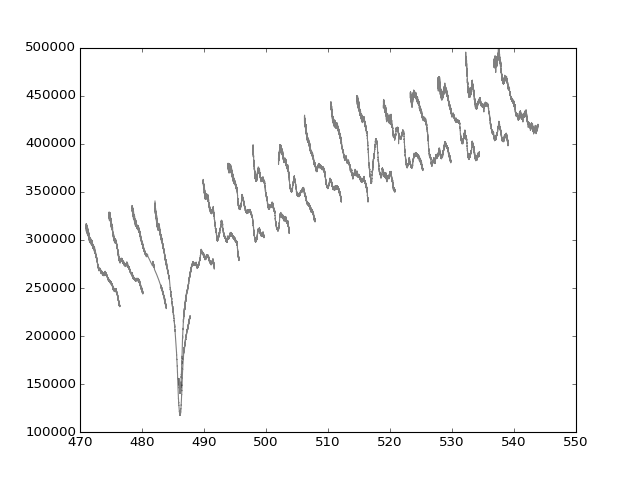

In [24]:
import HelperFunctions
orders = HelperFunctions.ReadExtensionFits(star_list[1])

import matplotlib.pyplot as plt
%matplotlib notebook
#nums = tuple(range(5, 16)) + tuple(range(18, 26))
nums = range(18, 35)
#for order in orders[4:25]:
good_orders = [o.copy() for i, o in enumerate(orders) if i in nums]
for order in good_orders:
    plt.plot(order.x, order.y, 'k-', alpha=0.5)

In [25]:
reload(SpecFlattener)
print(len(nums))
output = SpecFlattener.flatten_spec(star_list[1], hdf5_lib, teff=teff, logg=logg, normalize_model=False,
                                    first_order=4, last_order=15,
                                    ordernums=nums)
final_orders, flattened, shifted_orders, mcf = output


17
Determine Chunk Log: Wl is 131072

INFO:root:Initializing continuum for RV guess.
INFO:root:Estimating the RV and vsini by cross-correlation
INFO:root:T = 8840.0
logg = 4.0
RV = 7.02824126784
INFO:root:LogL = -6042274.26575

INFO:root:T = 8840.1
logg = 4.0
RV = 7.02824126784
INFO:root:LogL = -6070001.60465

INFO:root:T = 8840.0
logg = 4.1
RV = 7.02824126784
INFO:root:LogL = -5828002.90283

INFO:root:T = 8840.0
logg = 4.0
RV = 7.12824126784
INFO:root:LogL = -6064049.21974

INFO:root:T = 7000.0
logg = 4.5
RV = -100.0
INFO:root:LogL = -25853499.0435

INFO:root:T = 7000.1
logg = 4.5
RV = -100.0
INFO:root:LogL = -25851171.2588

INFO:root:T = 7000.0
logg = 4.6
RV = -100.0
INFO:root:LogL = -26447279.6108

INFO:root:T = 7000.0
logg = 4.5
RV = -99.9
INFO:root:LogL = -25845438.7397

INFO:root:T = 8240.25434041
logg = 4.16297436402
RV = -27.8574778376
INFO:root:LogL = -7999256.48193

INFO:root:T = 8240.35434041
logg = 4.16297436402
RV = -27.8574778376
INFO:root:LogL = -7998812.83404

INFO:root:T = 8240.25434041
logg = 4.2629743640

<IPython.core.display.Javascript object>


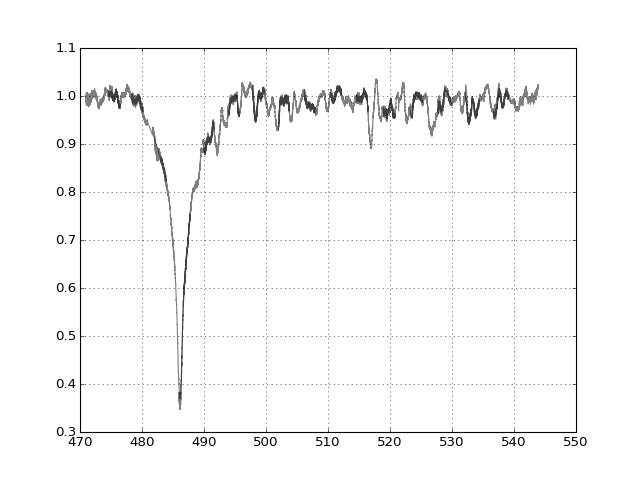

In [27]:

%matplotlib notebook
for order in final_orders:
    plt.plot(order.x, order.y, 'k-', alpha=0.5)